# Problem

This dataset is a record of 7 common different fish species in fish market sales. We want a model to estimate a fish's weight. 

# Summary of Results

***

In [3]:
!pip install kaggle

     |████████████████████████████████| 58 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 6.1 MB/s eta 0:00:011
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=26a9140f5c289cb6732dd91766a43206e90c762e99b0960bd3a72509a713e217
  Stored in directory: /home/jovyan/.cache/pip/wheels/29/da/11/144cc25aebdaeb4931b231e25fd34b394e6a5725cbb2f50106
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=56f23ad6e1ac20a0bcb4ec862c990abda0c1499f54a1454ee6e9e6406ac6bd74
  Stored in directory: /home/jovyan/.cache/pip/wheels/91/4d/4f/e740a68c215791688c46c4d6251770a570e8dfea91af1acb5c
Successfully built kaggle python-slugify


In [4]:
import kaggle

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

sns.set_theme(style="darkgrid")
%matplotlib inline

# Exploratory Data Analysis

In [5]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('aungpyaeap/fish-market', path='data/', unzip=True)

## Data Dictionary

* Species: Species name of fish
* Weight: Weight of fish in gram
* Length1: Vertical length in cm
* Length2: Diagonal length in cm
* Length3: Cross length in cm
* Height: Height in cm
* Width: Diagonal width in cm

In [6]:
data = pd.read_csv('./data/Fish.csv')

## Overview

First, we gather basic impressions and answer basic questions abou the data like,

* What do some sample values look like?
* How many rows are there and what are their types?

In [7]:
data.sample(frac=.1).head(10)

,Species,Weight,Length1,Length2,Length3,Height,Width
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672
23,Bream,680.0,31.8,35.0,40.6,15.4686,6.1306
117,Perch,650.0,36.5,39.0,41.4,11.1366,6.0030
137,Pike,500.0,42.0,45.0,48.0,6.9600,4.8960
128,Pike,200.0,30.0,32.3,34.8,5.5680,3.3756
54,Roach,390.0,29.5,31.7,35.0,9.4850,5.3550
21,Bream,685.0,31.4,34.0,39.2,15.9936,5.3704
133,Pike,345.0,36.0,38.5,41.0,6.3960,3.9770
60,Whitefish,1000.0,37.3,40.0,43.5,12.3540,6.5250
43,Roach,150.0,20.4,22.0,24.7,5.8045,3.7544


In [8]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


## Data Quality

* Is there missing data?
* Are columns the right types?
* Are there outliers in any of the columns?

#### *Is there missing data?*

In [9]:
print(str('Are there any missing values in the dataset?'), data.isnull().values.any())

Are there any missing values in the dataset? False


#### *Are columns the right types?*

In [10]:
pd.DataFrame(data['Species'].value_counts()).T

,Perch,Bream,Roach,Pike,Smelt,Parkki,Whitefish
Species,56,35,20,17,14,11,6


We can see from the data type displayed in the overview section and the data above that the `Species` columns is categorical.

In [11]:
 data['Species'] = data['Species'].astype('category')

#### *Are there outliers in any of the columns?*

Weights of fish that are less than or equal to 0 are not valid values.

In [12]:
data.loc[data.Weight <= 0].head()

,Species,Weight,Length1,Length2,Length3,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


In [13]:
fishes = data.loc[data.Weight > 0]

## Graphical Exploration

#### Distributional Observations

An early step in any effort to analyze or model data is understanding how the variables are distributed.

* What range do the observations cover? 
* What is their central tendency? 
* Are they heavily skewed in one direction? 
* Is there evidence for bimodality? 
* Are there significant outliers? 
* Do the answers to these questions vary across subsets defined by other variables?
* Is the response variable imbalanced?

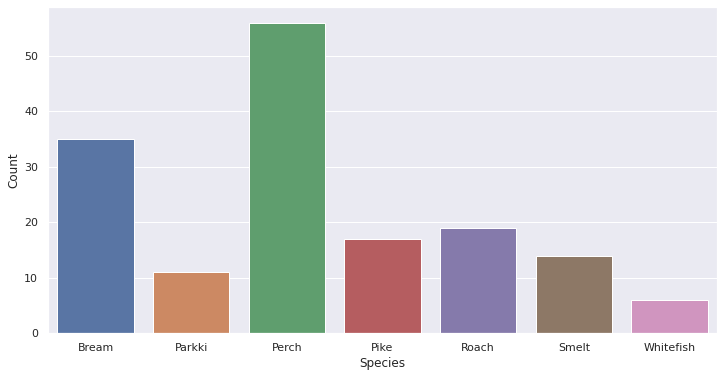

In [14]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x="Species", data=fishes);
ax.set_ylabel("Count")
plt.show()

*Observations*
* If the response variable were `Species` then this plot would tell use that we have an imbalanced dataset.

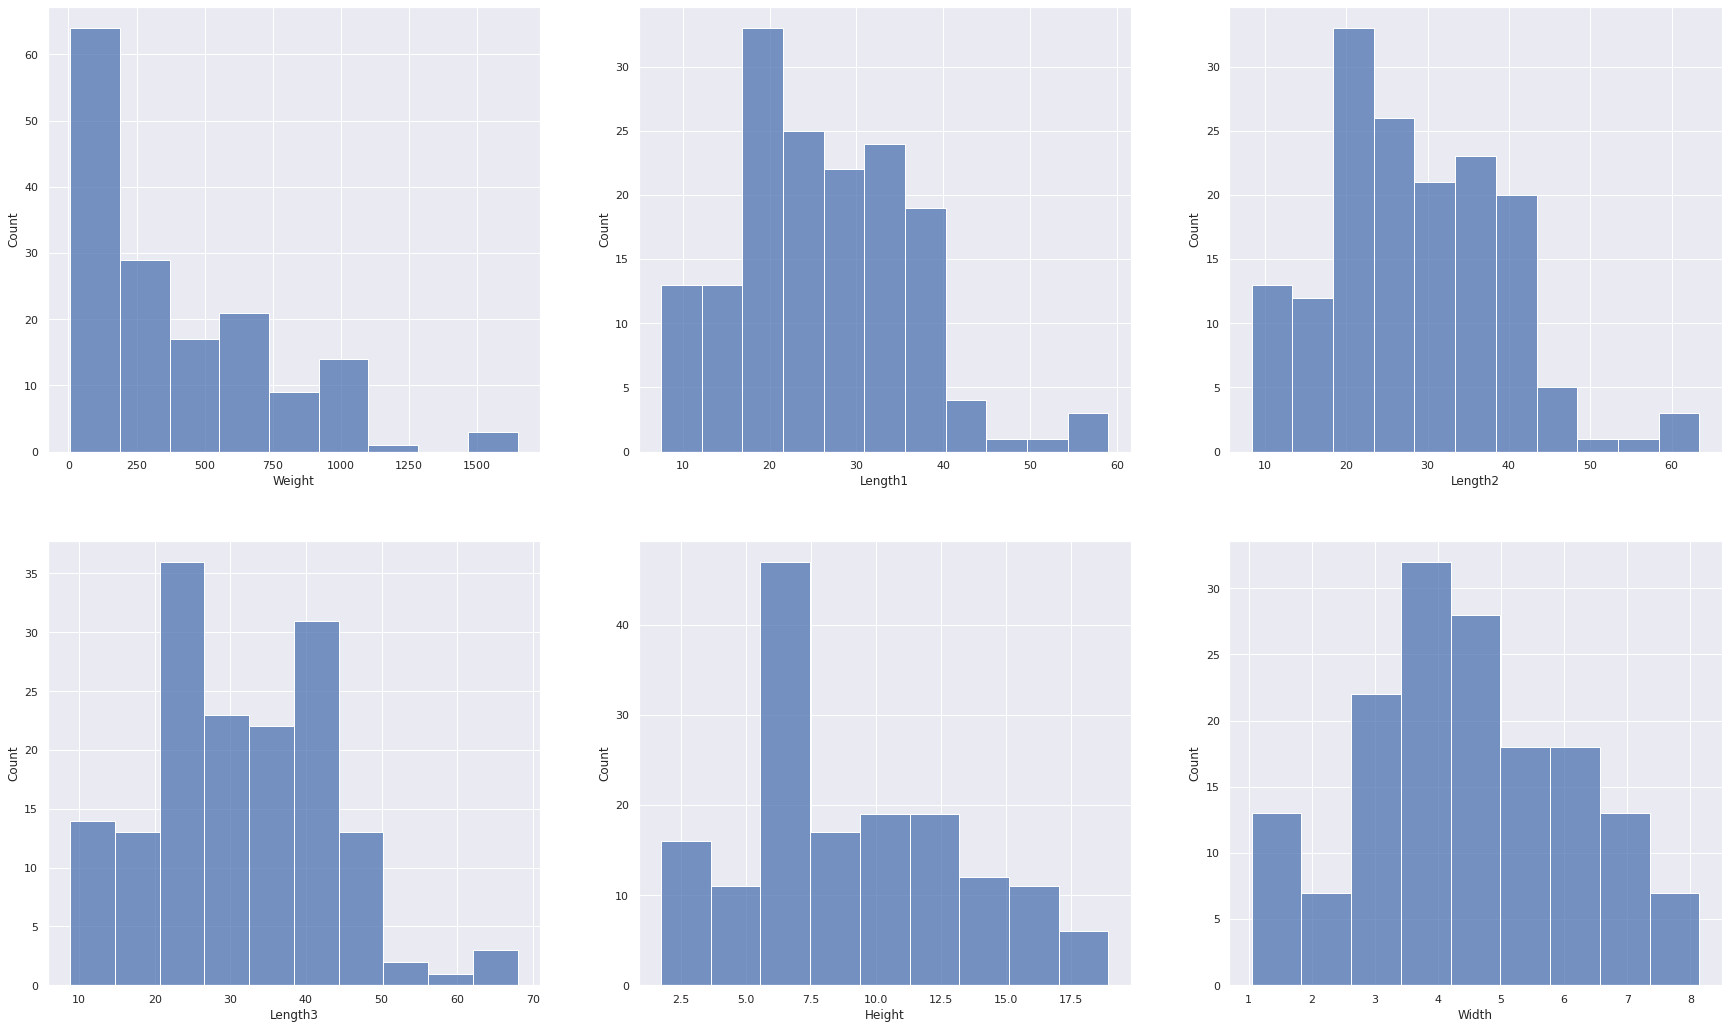

In [15]:
columns_for_hist = ['Weight','Length1','Length2','Length3','Height','Width']
fig, ax = plt.subplots(2, 3, squeeze=True, figsize=(30, 18))
for col, subplot in zip(columns_for_hist, ax.flatten()):
    sns.histplot(fishes, x=col, ax=subplot);

*Observations*
* Length[1,2,3] have nearly identical distributions 
* Width approximates an normal distribution. A normality test would provide more exact information.

#### Relationships

First I'll explore correlations. In statistical terms, correlation is a method of assessing a possible two-way linear association between two continuous variables. 

**Pearson's Correlation**

The Pearson product-moment correlation attempts to draw a line of best fit through the data of two variables. The Pearson correlation coefficient, *r*, indicates how far away all these data points are to this line of best fit (i.e., how well the data points fit this new model/line of best fit). The key assumptions of using this statistic are,

* Both variables being studied are normally distributed
* This coefficient is affected by extreme values, which may exaggerate or dampen the strength of relationship, and is therefore inappropriate when either or both variables are not normally distributed.

The condition of normal distribution isn't well satisfied from what we can see in the histograms above, but I examine the values for the purposes of understanding our problem.

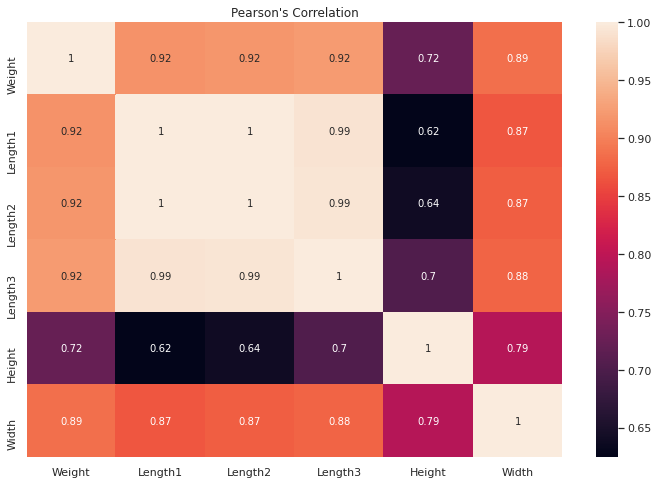

In [16]:
plt.figure(figsize=(12,8))
plt.title("Pearson's Correlation")
sns.heatmap(fishes.corr(), annot=True);
plt.show();

*Observations*
* The response variable, Weight, is most highly correlated with Length1, Length2 and Length3

**Spearmen's Correlation**



The key assumptions of using this statistic are,

* It is appropriate when one or both variables are skewed or ordinal1 and is robust when extreme values are present.

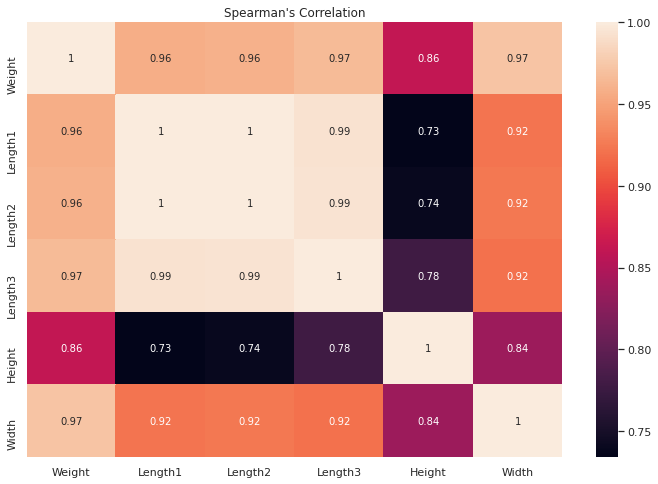

In [17]:
plt.figure(figsize=(12,8))
plt.title("Spearman's Correlation")
sns.heatmap(fishes.corr(method='spearman'), annot=True);
plt.show();

*Observations*
* In contrast to Pearson's correlation we see that highest correlation of Weight between Width and Length3. 

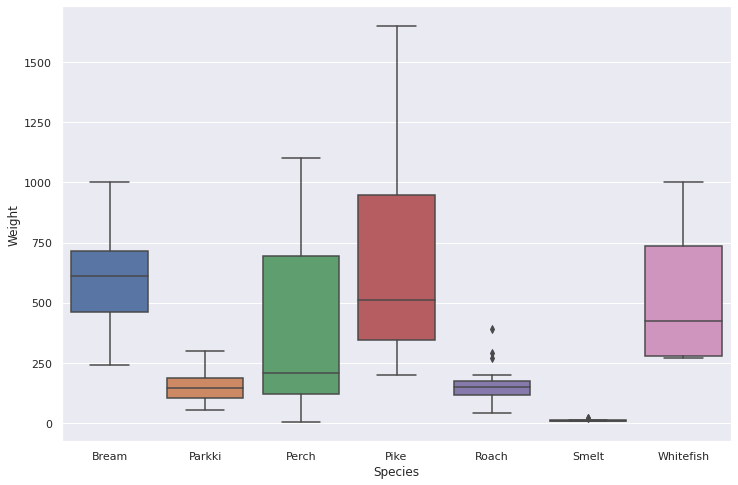

In [18]:
plt.figure(figsize=(12,8))
sns.boxplot(x='Species', y='Weight', data=fishes);
plt.show();

*Observations*
* ...

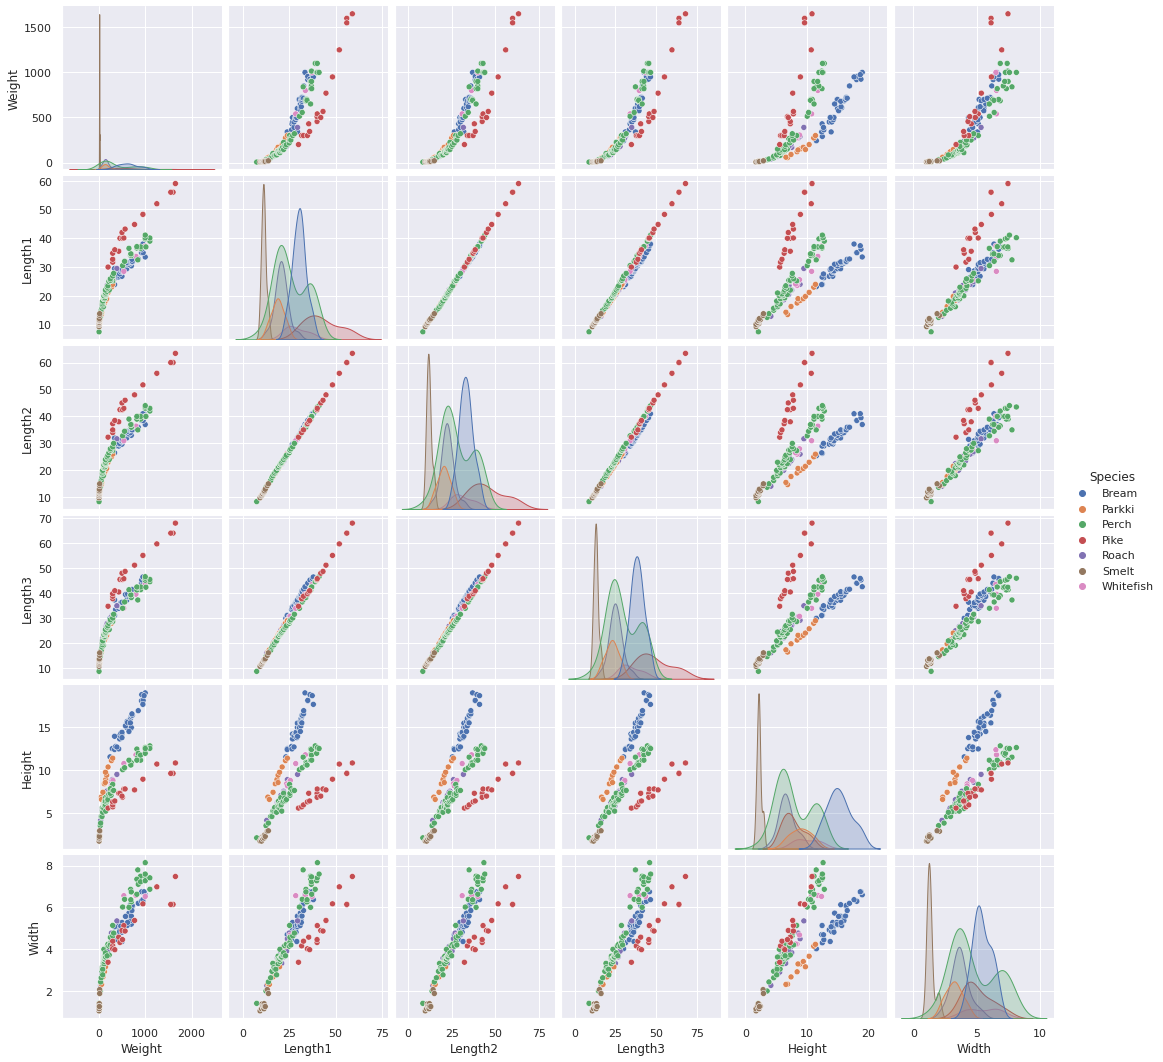

In [19]:
g = sns.pairplot(fishes, kind='scatter', hue='Species');

*Observations*

* ...

# The Model

We saw from Spearmen's correlation and the pair plot above that there are strong linear relationships betweeen `Weight` and serveral of the other variables. 

In [21]:
y = fishes['Weight']
X = fishes.drop(columns=['Weight'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)